<a href="https://colab.research.google.com/github/juanpajedrez/FreeCodeCamp-MLforEverybody/blob/main/fcc_bikes_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
from pathlib import Path
import copy
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression

### Dataset:

The dataset we are using are Seoul biking dataset from: https://archive.ics.uci.edu/dataset/560/seoul+bike+sharing+demand

In [67]:
dataset_cols = ["bike_count", "hour", "temp", "humidity", "wind", "visibility", "dew_pt_temp", "radiation", "rain", "snow", "functional"]

### Read the dataset

Funny enough, you might need to modify the dataset to remove degrees sign from the columns inside the csv file to make it work :)

In [68]:
data_path = Path("sample_data").joinpath("SeoulBikeData.csv")
print(data_path.exists())

True


In [69]:
df = pd.read_csv(data_path).drop(["Date", "Holiday", "Seasons"], axis = 1)

In [70]:
df.columns = dataset_cols

# Map them into 1 and zeroes for the functional column
df["functional"] = (df["functional"] == "Yes").astype(int)

#Select the data from noon
df = df[df["hour"] == 12]
df = df.drop("hour", axis = 1)

In [71]:
df.head()

,bike_count,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
12,449,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,1
36,479,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,1
60,333,5.8,85,1.7,349,3.4,0.43,0.0,0.0,1
84,393,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,1
108,321,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,1


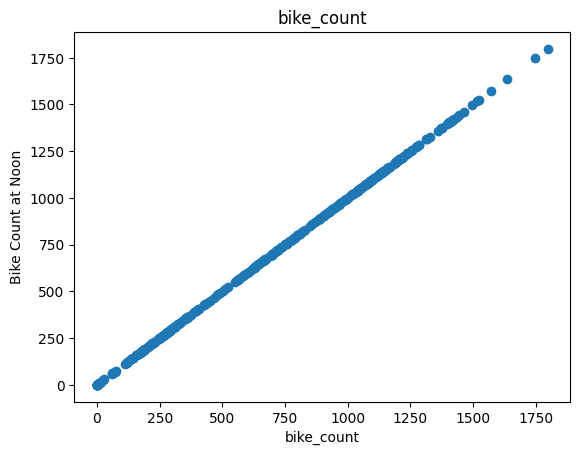

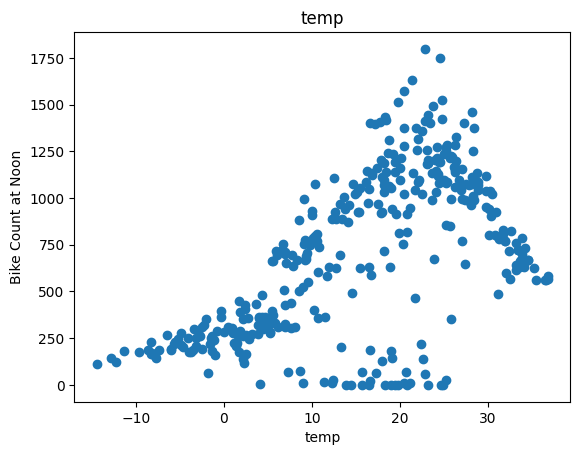

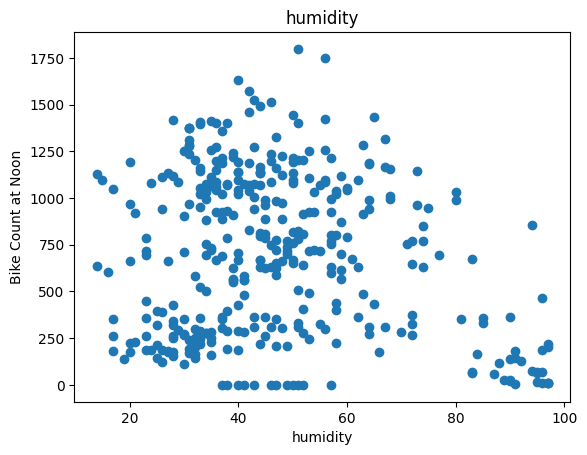

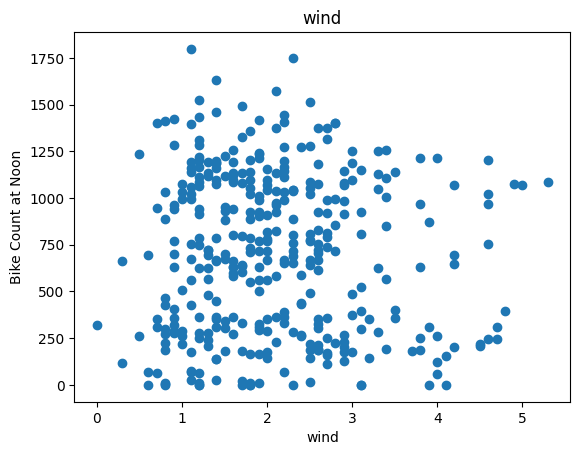

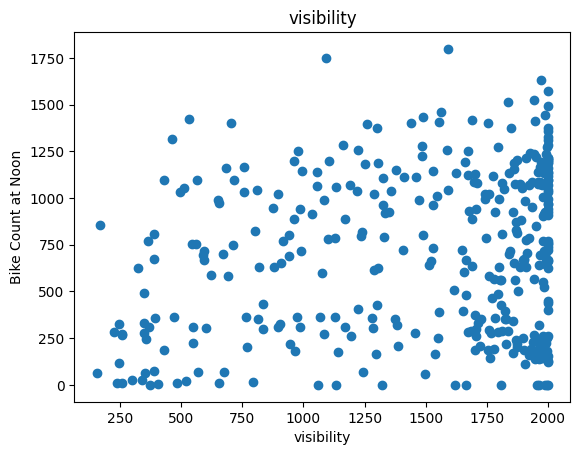

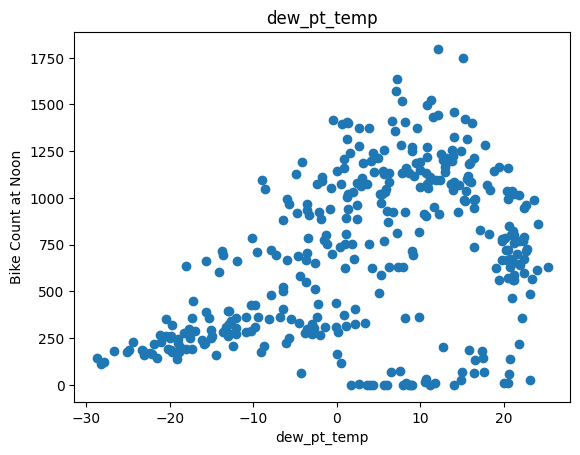

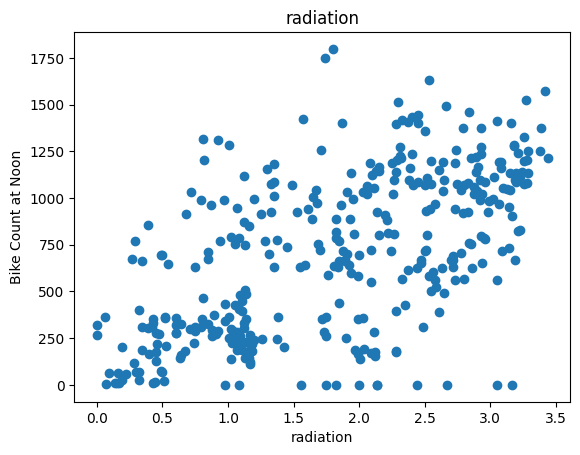

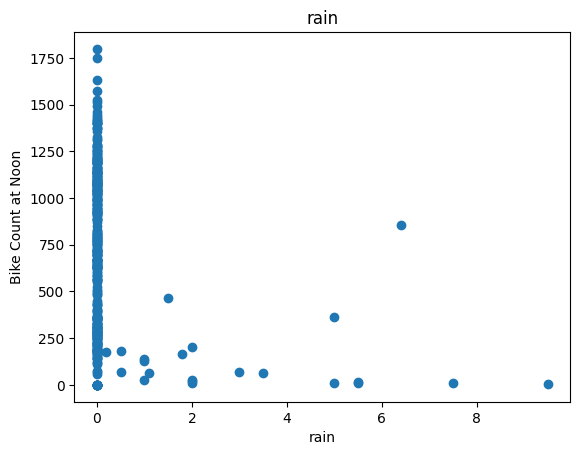

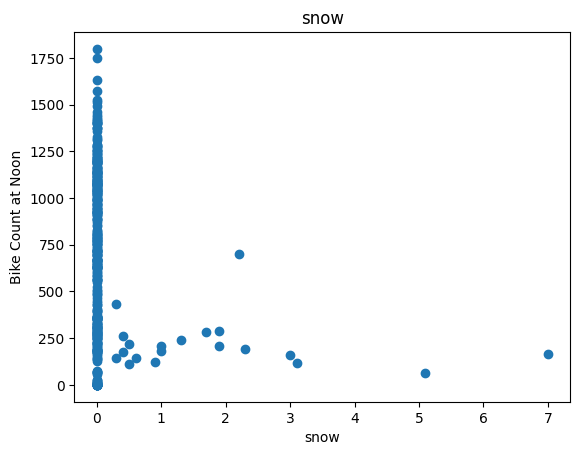

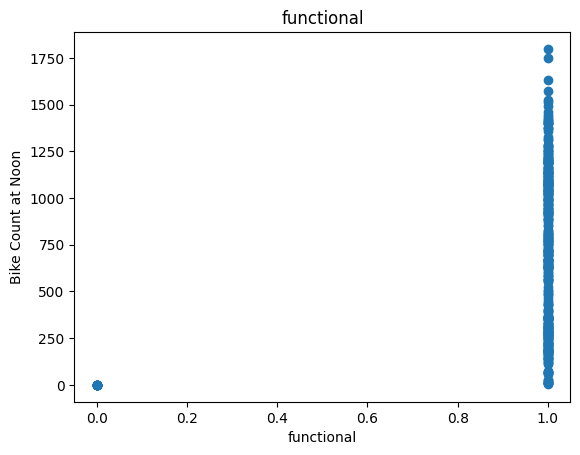

In [72]:
for label in df.columns:
    plt.scatter(df[label], df["bike_count"])
    plt.title(label)
    plt.ylabel("Bike Count at Noon")
    plt.xlabel(label)
    plt.show()


### EDA Data Preprocessing: Getting rid of wind, visibility and functional

In [73]:
df = df.drop(["wind", "visibility", "functional"], axis = 1)

In [74]:
df.head()

,bike_count,temp,humidity,dew_pt_temp,radiation,rain,snow
12,449,1.7,23,-17.2,1.11,0.0,0.0
36,479,4.3,41,-7.8,1.09,0.0,0.0
60,333,5.8,85,3.4,0.43,0.0,0.0
84,393,-0.3,38,-12.9,1.11,0.0,0.0
108,321,-2.3,25,-19.7,0.00,0.0,0.0


### Train, test, split

In [75]:
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [83]:
def get_xy(data, y_label, x_labels = None):
  dataframe = copy.deepcopy(data)
  if not x_labels:
    X = dataframe[[c for c in dataframe.columns if c != y_label]].values
  else:
    if len(x_labels) == 1:
      X = dataframe[x_labels[0]].values.reshape(-1, 1)
    else:
      X = dataframe[x_labels].values

  y = dataframe[y_label].values
  return data, X, y

In [77]:
_, X_train_temp, y_train_temp = get_xy(train, "bike_count", x_labels = ["temp"])
_, X_val_temp, y_val_temp = get_xy(val,  "bike_count",  x_labels = ["temp"])
_, X_test_temp, y_test_temp = get_xy(test,  "bike_count", x_labels = ["temp"])

In [78]:
temp_reg = LinearRegression()
temp_reg.fit(X_train_temp, y_train_temp)

LinearRegression()

In [79]:
print(temp_reg.coef_, temp_reg.intercept_)

[22.03069417] 363.22196456921097


In [80]:
print(temp_reg.score(X_test_temp, y_test_temp))

0.18504843045751185


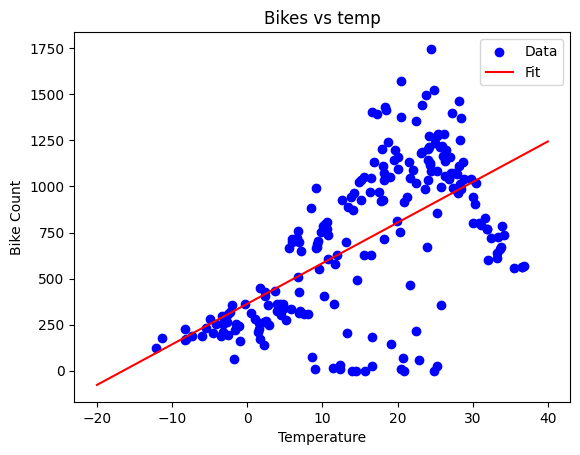

In [81]:
plt.scatter(X_train_temp, y_train_temp, label = "Data", color = "b")
x = np.linspace(-20, 40, 100)
plt.plot(x, temp_reg.predict(x.reshape(-1, 1)), label = "Fit", color = "r")
plt.title("Bikes vs temp")
plt.ylabel("Bike Count")
plt.xlabel("Temperature")
plt.legend()


## Multiple Linear Regression

In [84]:
# Follwing the method in the video for np.split, in the future I would use train_test_split from sklearn
# or the Iloc command from dataframes
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])
_, X_train_all, y_train_all = get_xy(train, "bike_count", x_labels = df.columns.names[1:])
_, X_val_all, y_val_all = get_xy(val,  "bike_count",  x_labels = df.columns.names[1:])
_, X_test_all, y_test_all = get_xy(test,  "bike_count", x_labels = df.columns.names[1:])

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [85]:
all_reg = LinearRegression()
all_reg.fit(X_train_all, y_train_all)

LinearRegression()

In [86]:
all_reg.score(X_test_all, y_test_all)

0.49176927566806306

## Regression with a Neural Net: Simple with one variable, temperature

In [92]:
temp_normalizer = tf.keras.layers.Normalization(axis = None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

In [103]:
temp_nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(1, activation="relu")
]
)

In [104]:
from tensorflow.keras.optimizers import Adam

temp_nn_model.compile(optimizer = Adam(learning_rate = 0.1), loss = "mean_absolute_error")

In [105]:
history = temp_nn_model.fit(X_train_temp, y_train_temp, epochs = 1000, validation_data = (X_val_temp, y_val_temp))

Epoch 1/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 663.9915 - val_loss: 626.8486
Epoch 2/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 724.1079 - val_loss: 626.3112
Epoch 3/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 723.4235 - val_loss: 625.7489
Epoch 4/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 656.2025 - val_loss: 625.1647
Epoch 5/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 720.1453 - val_loss: 624.5718
Epoch 6/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 686.1282 - val_loss: 623.9722
Epoch 7/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 673.6305 - val_loss: 623.3680
Epoch 8/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 658.7817 - val_loss: 622.7589
Epoch 9/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 693.0102 - val_loss: 622.1404
Epoch 10/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 718.9744 - val_loss: 621.5230
Epoch 11/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 676.9553 - val_loss: 620.9100
Epoch 12/1000
7/7 ━

In [106]:
def plot_loss(history):
  fig, ax1 = plt.subplots(1, 1, figsize = (15, 5))
  ax1.plot(history.history["loss"], label = "loss")
  ax1.plot(history.history["val_loss"], label = "val_loss")
  ax1.set_xlabel("Epoch")
  ax1.set_ylabel("MSE")
  ax1.legend()
  ax1.grid(True)

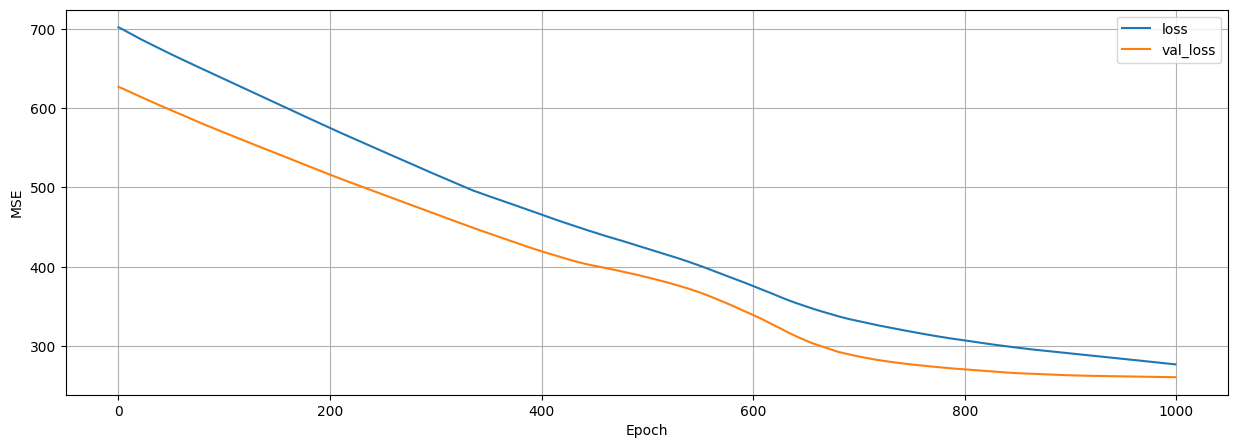

In [107]:
plot_loss(history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


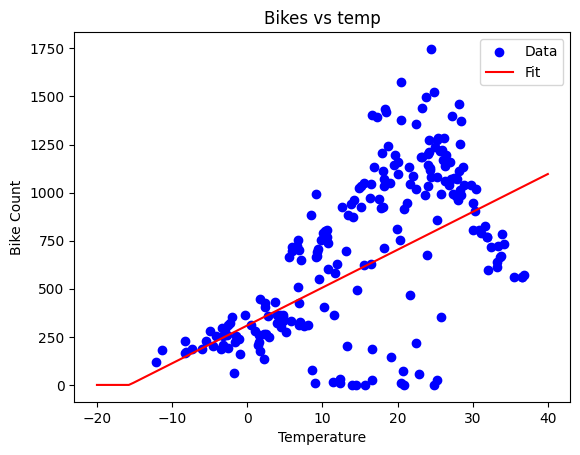

In [108]:
plt.scatter(X_train_temp, y_train_temp, label = "Data", color = "b")
x = np.linspace(-20, 40, 100)
plt.plot(x, temp_nn_model.predict(x.reshape(-1, 1)), label = "Fit", color = "r")
plt.title("Bikes vs temp")
plt.ylabel("Bike Count")
plt.xlabel("Temperature")
plt.legend()

## Neural Net: Multiple linear regression with multiple features

In [136]:
all_normalizer = tf.keras.layers.Normalization(axis = None)
all_normalizer.adapt(X_train_all)

nn_model = tf.keras.Sequential([
    all_normalizer,
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(1),
]
)

nn_model.compile(optimizer = Adam(learning_rate = 0.01), loss = "mean_absolute_error")

In [137]:
history = nn_model.fit(X_train_all, y_train_all,\
  epochs = 200, validation_data = (X_val_all, y_val_all))

Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 724.2291 - val_loss: 676.2067
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 709.6115 - val_loss: 668.0338
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 681.8714 - val_loss: 649.7529
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 674.2153 - val_loss: 615.0427
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 609.9034 - val_loss: 553.5819
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 562.1385 - val_loss: 469.3701
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 501.4781 - val_loss: 403.7043
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 440.7435 - val_loss: 365.7378
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 411.5574 - val_loss: 379.9840
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 391.0452 - val_loss: 374.9593
Epoch 11/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 369.6406 - val_loss: 356.8442
Epoch 12/200
7/7 ━━━━━━━━━━━━━

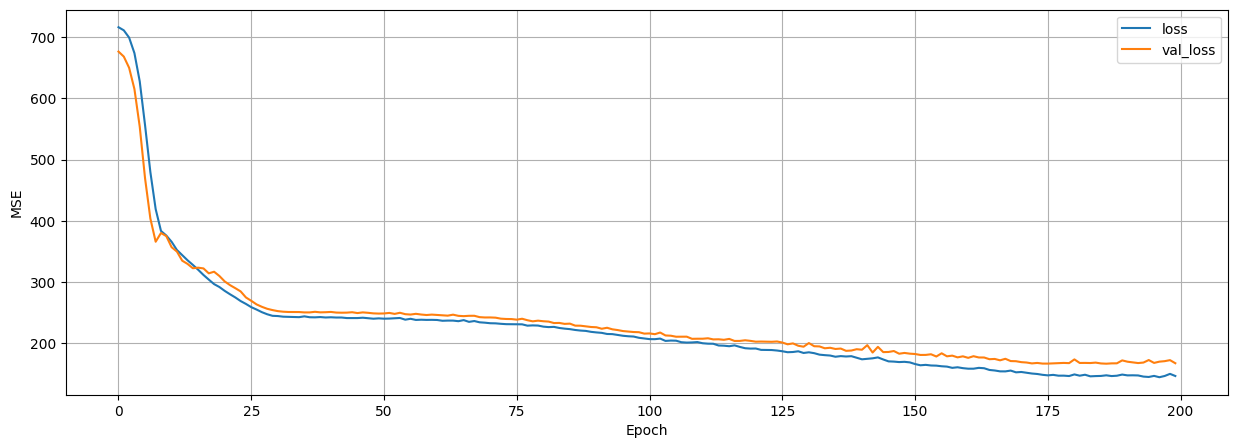

In [138]:
plot_loss(history)

In [139]:
def MSE(y_pred, y_true):
  return np.mean((y_pred - y_true) ** 2)

# Calculate the MSE between the linear regression model, neural net with one variable model, and multiple linear regression
y_pred_lr = all_reg.predict(X_test_all)
y_pred_multiple_nn = nn_model.predict(X_test_all)

mse_lr = MSE(y_pred_lr, y_test_all)
mse_multiple_nn = MSE( y_pred_multiple_nn, y_test_all)

print(f"MSE for multiple linear regression: {mse_lr}")
print(f"MSE for neural net with multiple variables: {mse_multiple_nn}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
MSE for multiple linear regression: 100399.93833393061
MSE for neural net with multiple variables: 335206.81748937967


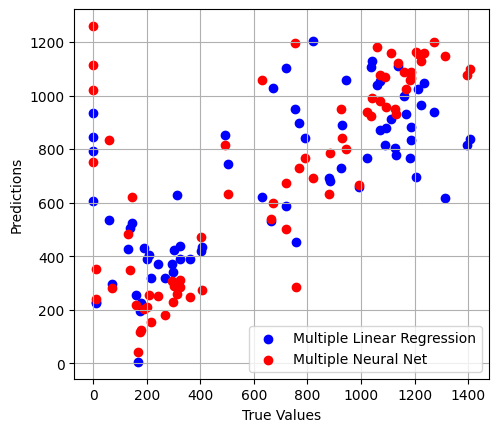

In [140]:
ax = plt.axes(aspect = "equal")
plt.scatter(y_test_all, y_pred_lr, label = "Multiple Linear Regression", color = "b")
plt.scatter(y_test_all, y_pred_multiple_nn, label = "Multiple Neural Net", color = "r")
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.legend()
plt.grid(True)